# Using simple CNN to predict stock price

Contributor : 
1. Marcello Susanto-10116017
2. Suparjo-10116031



## Import Package
we will import the package that will be used to define the function of technical indicator of stock price for preprocessing step

In [0]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import re
from sklearn.preprocessing import MinMaxScaler 

## Definition of technical Indicator
The techincal indicator that we will use are listed below:
1. Simple Moving Average (SMA)
2. Exponential Moving Average (EMA)
3. Volume Weighted Average Price (VWAP)
4. Moving Average Convergence/Divergence (MACD)
5. Stochastic Oscillator (STOCH)
6. Relative Strength Index (RSI)
7. Average Directional Movement Index (ADX)
8. Commodity Channel Index (CCI)
9. Aroon (AROON)
10. Bollinger Bands (BBANDS)
11. Chalkin Accumulation/Distribution (AD)
12. On Balance Volume (OBV) <bv/>
    
the reference: www.alphavantage.co and using 12 techincal indicators that are commonly used

example to call the function:
>technical_dicts(dataframe, ['SMA(5)','OBV','BBANDS(15)'])

In [0]:
# Technical Indicator Function

def technical_dicts(temp_df, i):
    dummy_df = pd.DataFrame()
    dummy_df = temp_df.copy()
    
    # split the technical indicator and its parameter (commonly period)
    technical_indicator = re.findall('-?\w+',i)[0]
    parameter = re.findall('-?\w+',i)[1:]

    # Simple Moving Average 
    if technical_indicator == 'SMA':
        time_period = int(parameter[0])
        sma = [np.nan]*time_period
        for j in range(time_period,len(dummy_df)):
            cal = np.mean(dummy_df.loc[j-time_period:j-1, 'Close'])
            sma.append(cal)
        temp_df[i] = sma
        
    # Exponential Moving Average 
    if technical_indicator == 'EMA':
        smoothing = 2
        dummy_df[i] = np.nan  
        ema = [dummy_df['Close'][:int(parameter[0])].values.mean()]
        for j in range(int(parameter[0]), temp_df.shape[0]):
            ema.append((dummy_df.loc[j,'Close']*(smoothing/(1+int(parameter[0])))) + 
                       (ema[-1]*(1-(smoothing/(1+int(parameter[0]))))))
        dummy_df.loc[dummy_df.shape[0]-len(ema):,i] = ema
        temp_df[i] = dummy_df[i]
        
    # Volume Weighted Average Price
    if technical_indicator == 'VWAP':
        time_period = int(parameter[0])
        dummy_df['Vol*Close'] = dummy_df['Close'] * dummy_df['Volume']
        vwap = [np.nan]*time_period
        for j in range(time_period,len(dummy_df)):
            cal = np.sum(dummy_df.loc[j-time_period:j-1, 'Vol*Close']) / np.sum(dummy_df.loc[j-time_period:j-1, 'Volume'])
            vwap.append(cal)
        dummy_df.drop(columns=['Vol*Close'], inplace=True)
        temp_df[i] = vwap
        
    # Moving Average Convergence/Divergence
    if technical_indicator == 'MACD':
        smoothing = 2
        dummy_df['first'] = np.nan  
        ema1 = [dummy_df['Close'][:int(parameter[0])].values.mean()]
        for j in range(int(parameter[0]), temp_df.shape[0]):
            ema1.append((dummy_df.loc[j,'Close']*(smoothing/(1+int(parameter[0])))) + 
                       (ema1[-1]*(1-(smoothing/(1+int(parameter[0]))))))
        dummy_df.loc[dummy_df.shape[0]-len(ema1):,'first'] = ema1 

        dummy_df['second'] = np.nan  
        ema2 = [dummy_df['Close'][:int(parameter[1])].values.mean()]
        for j in range(int(parameter[1]), temp_df.shape[0]):
            ema2.append((dummy_df.loc[j,'Close']*(smoothing/(1+int(parameter[1])))) + 
                       (ema2[-1]*(1-(smoothing/(1+int(parameter[1]))))))
        dummy_df.loc[dummy_df.shape[0]-len(ema2):,'second'] = ema2             
        temp_df[i] = dummy_df['second'] - dummy_df['first'] 
        
    # Make Stochastic Oscillator (STOCH)
    if technical_indicator == 'STOCH':
        time_period = int(parameter[0])
        stoch_period = 3
        stoch_slow = [np.nan]*time_period
        stoch_fast = [np.nan]*(time_period + stoch_period)

        for j in range(time_period,len(dummy_df)):
            close = dummy_df.loc[j-1, 'Close']
            lowest_low = np.min(dummy_df.loc[j-time_period:j-1, 'Low'])
            highest_high = np.max(dummy_df.loc[j-time_period:j-1, 'High'])

            if highest_high == lowest_low :
                cal = 0
            else :
                cal = 100 * (close - lowest_low) / (highest_high - lowest_low)

            stoch_slow.append(cal)

            if j >= (time_period + stoch_period) :
                fast_cal = np.mean(stoch_slow[j-stoch_period:j])
                stoch_fast.append(fast_cal)

        temp_df['{}_F({})'.format(technical_indicator,parameter[0])] = stoch_fast
        temp_df['{}_S({})'.format(technical_indicator,parameter[0])]  = stoch_slow
              
    # Relative Strength Index
    if technical_indicator == 'RSI':
        dummy_df[i] = np.nan
        subtract = dummy_df['Close'] - dummy_df['Open']
        ag = np.array([i if i >=0 else 0 for i in subtract[0:int(parameter[0])]]).sum()
        al = np.array([abs(i) if i <0 else 0 for i in subtract[0:int(parameter[0])]]).sum()
        rsi = [100 - (100/(1+(ag/al)))]
        for j in range(int(parameter[0]), temp_df.shape[0]):
            if subtract[j] >= 0 :
                ag = (ag*(int(parameter[0])-1) + subtract[j])/(int(parameter[0]))
                al = (al*(int(parameter[0])-1))/(int(parameter[0]))
            else:
                ag = (ag*(int(parameter[0])-1))/(int(parameter[0]))
                al = (al*(int(parameter[0])-1) + abs(subtract[j]))/(int(parameter[0]))
            rsi.append(100 - (100/(1+(ag/al))))          
        dummy_df.loc[temp_df.shape[0]-len(rsi):,i] = rsi
        temp_df[i] = dummy_df[i]
        

    # Make Average Directional Index (ADX)
    if technical_indicator == 'ADX':
        time_period = int(parameter[0])
        
        # Make True Range (TR)
        dummy_df['High Low'] = dummy_df['High'] - dummy_df['Low']
        high_close = [np.nan]
        low_close = [np.nan]

        for j in range(1,len(dummy_df)) :
            delta_h = np.abs(dummy_df.loc[j, 'High'] - dummy_df.loc[j-1, 'Close'])
            delta_l = np.abs(dummy_df.loc[j, 'Low'] - dummy_df.loc[j-1, 'Close'])

            high_close.append(delta_h)
            low_close.append(delta_l)

        dummy_df['High Close'] = high_close
        dummy_df['Low Close'] = low_close
        dummy_df['True Range'] = np.max(dummy_df[['High Low','High Close','Low Close']], axis=1)

        # Make Directional Movement (DM)
        plus_DM = [np.nan]
        minus_DM = [np.nan]

        for j in range(1,len(dummy_df)) :
            delta_h = dummy_df.loc[j-1, 'High'] - dummy_df.loc[j, 'High']
            delta_l = dummy_df.loc[j, 'Close'] - dummy_df.loc[j-1, 'Close']
            if (delta_h < 0 and delta_l < 0) or delta_h == delta_l :
                pdm = 0
                mdm = 0
            elif delta_h > delta_l :
                pdm = delta_h
                mdm = 0
            elif delta_h < delta_l :
                pdm = 0
                mdm = delta_l

            plus_DM.append(pdm)
            minus_DM.append(mdm)

        dummy_df['+DM'] = plus_DM
        dummy_df['-DM'] = minus_DM

        # Make Smoothed TR and DMI
        smooth_period = 3
        smooth_tr = [np.nan] * (1+smooth_period) + [np.sum(dummy_df[dummy_df['True Range'].notnull()]['True Range'][:smooth_period])]
        smooth_pdm = [np.nan] * (1+smooth_period) + [np.sum(dummy_df[dummy_df['+DM'].notnull()]['+DM'][:smooth_period])]
        smooth_mdm = [np.nan] * (1+smooth_period) + [np.sum(dummy_df[dummy_df['-DM'].notnull()]['-DM'][:smooth_period])]

        for j in range(2+smooth_period,len(dummy_df)) :
            tr = smooth_tr[-1] - (smooth_tr[-1] / smooth_period) + dummy_df.loc[j, 'True Range']
            pdm = smooth_pdm[-1] - (smooth_pdm[-1] / smooth_period) + dummy_df.loc[j, '+DM']
            mdm = smooth_mdm[-1] - (smooth_mdm[-1] / smooth_period) + dummy_df.loc[j, '-DM']

            smooth_tr.append(tr)
            smooth_pdm.append(pdm)
            smooth_mdm.append(mdm)

        dummy_df['Smoothed True Range'] = smooth_tr
        dummy_df['Smoothed +DM'] = smooth_pdm
        dummy_df['Smoothed -DM'] = smooth_mdm

        # Make Directional Movement Index (DMI)
        dummy_df['+DI'] = 100 * (dummy_df['Smoothed +DM'] / dummy_df['Smoothed True Range'])
        dummy_df['-DI'] = 100 * (dummy_df['Smoothed -DM'] / dummy_df['Smoothed True Range'])

        # Make Directional Movement Index II (DX)
        dummy_df['DX'] = np.abs(100 * (dummy_df['+DI'] - dummy_df['-DI']) / (dummy_df['+DI'] + dummy_df['-DI']))

        # Make ADX
        adx = [np.nan] * (1+smooth_period+time_period) + [np.mean(dummy_df[dummy_df['DX'].notnull()]['DX'][:time_period])]

        for j in range(2+smooth_period+time_period,len(dummy_df)) :
            cal = (adx[-1] * (time_period-1) + dummy_df.loc[j, 'DX']) / time_period
            adx.append(cal)

        list_var = ['High Low','High Close','Low Close','True Range','+DM','-DM','Smoothed True Range','Smoothed +DM','Smoothed -DM','+DI','-DI','DX']
        dummy_df.drop(columns=list_var, inplace=True)
        temp_df[i] = np.array(adx)      
        
        
    # Commodity Channel Index                 
    if technical_indicator == 'CCI':
        dummy_df['TP'] = (dummy_df['High'] + dummy_df['Low'] + dummy_df['Close'])/3
        dummy_df[i] = np.nan
        cci = []
        for j in range(int(parameter[0])-1, temp_df.shape[0]):
            sub_list = dummy_df.loc[j-int(parameter[0])+1:j,'TP']
            abs_dev = np.array([abs(k - sub_list.mean()) for k in sub_list]).mean()
            cci.append((dummy_df.loc[j,'TP'] - sub_list.mean())/(0.015*abs_dev))
        
        dummy_df.loc[dummy_df.shape[0]-len(cci):,i] = cci
        temp_df[i] = dummy_df[i]
        
    # Make AROON
    if technical_indicator == 'AROON':
        time_period = int(parameter[0])
        aroon_up = [np.nan]*time_period
        aroon_down = [np.nan]*time_period

        for j in range(time_period,len(dummy_df)) :
            high = list(dummy_df.loc[j-time_period:j-1, 'High'])
            high_idx = [j for j,val in enumerate(high) if val == np.max(high)][-1]
            up = 100 * ((time_period - high_idx) / time_period)

            low = list(dummy_df.loc[j-time_period:j-1, 'Low'])
            low_idx = [j for j,val in enumerate(low) if val == np.min(low)][-1]
            down = 100 * ((time_period - low_idx) / time_period)

            aroon_up.append(up)
            aroon_down.append(down)

        temp_df['AROON_U({})'.format(parameter[0])] = np.array(aroon_up)
        temp_df['AROON_D({})'.format(parameter[0])] = np.array(aroon_down)
        
    # Bollinger Bands    
    if technical_indicator == 'BBANDS':
        dummy_df['TP'] = (dummy_df['High'] + dummy_df['Low'] + dummy_df['Close'])/3
        dummy_df['U'] = np.nan
        dummy_df['L'] = np.nan
        bbands_u = []
        bbands_l = []
        for j in range(int(parameter[0])-1, temp_df.shape[0]):
            sub_list = dummy_df.loc[j-int(parameter[0])+1:j,'TP']
            abs_dev = np.array([abs(k - sub_list.mean()) for k in sub_list]).mean()
            bbands_u.append(sub_list.mean() + 2*abs_dev)
            bbands_l.append(sub_list.mean() - 2*abs_dev)
            
        dummy_df.loc[dummy_df.shape[0]-len(bbands_u):,'U'] = bbands_u
        dummy_df.loc[dummy_df.shape[0]-len(bbands_l):,'L'] = bbands_l
        
        temp_df['{}_U({})'.format(technical_indicator,parameter[0])] = dummy_df['L']
        temp_df['{}_L({})'.format(technical_indicator,parameter[0])]  = dummy_df['L']
        
    # Chalkin Accumulation/Distribution
    if technical_indicator =='AD':
        dummy_df['CLV'] = ((dummy_df['Close'] - dummy_df['Low']) - (dummy_df['High'] - dummy_df['Close'])) / (dummy_df['High'] - dummy_df['Low'])
        dummy_df['CLV'] = dummy_df['CLV'].fillna(0)
        dummy_df['VolCLV'] = dummy_df['CLV'] * dummy_df['Volume']
        ad = [dummy_df.loc[0, 'VolCLV']]

        for i in range(1,len(dummy_df)) :
            cal = ad[-1] + dummy_df.loc[i, 'VolCLV']
            ad.append(cal)

        dummy_df.drop(columns=['CLV','VolCLV'], inplace=True)
        temp_df['AD'] = ad
        
    # On Balance Volume   
    if technical_indicator == 'OBV':
        dummy_df[i] = np.nan
        obv = [0]
        for j in range(1,temp_df.shape[0]):
            if (dummy_df.loc[j,'Close'] - dummy_df.loc[j-1,'Close']) > 0:
                obv.append(obv[-1] + dummy_df.loc[j,'Volume'])
            elif (dummy_df.loc[j,'Close'] - dummy_df.loc[j-1,'Close']) < 0:
                obv.append(obv[-1] - dummy_df.loc[j,'Volume'])
            else:
                obv.append(obv[-1])
        
        dummy_df.loc[dummy_df.shape[0]-len(obv):,i] = obv
        temp_df[i] = dummy_df[i] 
        

## Determine the class

the class for preprocessing step consist of 3 functions, those are initiation (input data), scaling, adding technical indicator, indicator selection, and data splitting

In [0]:
class CNN_Technical_Stock_Model:
    def __init__(self, stock_data):
        try :
            # input the data
            self.df = pd.read_csv(stock_data)
            print('Data Load successfully \n')
        except:
            print('Invalid Data Format')
    
    # function for standarization
    def Standarized(self):
        for col in self.df.columns:
            scaler = MinMaxScaler()
            self.temp_df.loc[:,col] = scaler.fit_transform(np.array(self.temp_df.loc[:,col]).reshape(-1, 1))
    
    # function for adding technical indicator
    def Technical_Indicator(self, lists):
        temp_df = self.df
        for i in lists:
            # check the format of the technical indicator
            try:
                technical_dicts(temp_df, i)
            except:
                print('Wrong Format on {}'.format(i))
                continue
        self.temp_df = temp_df.dropna()
        return self.temp_df
    
    # variable selection
    def Select(self,lists):
        self.temp_df = self.temp_df[lists]
    
    # data splitting
    def Split_Data(self, window, split):
        data = self.temp_df.values.reshape(self.temp_df.values.shape[0],1,self.temp_df.values.shape[1])
        windowed_feature = []
        windowed_target = []
        for i in range(data.shape[0]-window):
            windowed_feature.append(data[i:i+window].tolist())
            windowed_target.append(data[i+window][0][3])
        train_x = np.array(windowed_feature[:-split])
        train_y = np.array(windowed_target[:-split])
        test_x = np.array(windowed_feature[-split:])
        test_y = np.array(windowed_target[-split:])
       
        return train_x, train_y, test_x, test_y
        

## Preprocessing data

In [0]:
# list of the technical indicators that will be used
all = ['SMA(15)','SMA(30)','SMA(60)',
       'EMA(15)','EMA(30)','EMA(60)',
       'VWAP(15)','VWAP(30)','VWAP(60)',
       'MACD(15,30)','MACD(30,60)','MACD(15,60)',
       'STOCH(15)','STOCH(30)','STOCH(60)',
       'RSI(15)','RSI(30)','RSI(60)',
       'ADX(15)','ADX(30)','ADX(60)',
       'CCI(15)','CCI(30)','CCI(60)',
       'AROON(15)','AROON(30)','AROON(60)',
       'BBANDS(15)','BBANDS(30)','BBANDS(60)',
       'AD','OBV']

In [0]:
# input using BBCA.JK data
cenya  = CNN_Technical_Stock_Model('BBCA.JK.csv')
# add all technical indicator that are listed from 'all'
cenya.Technical_Indicator(all)
# standarized the data
cenya.Standarized()
# split the data (5 timestep and 300 lastest data for the testing)
x_train, y_train, x_test, y_test = cenya.Split_Data(5,300)

Data Load successfully 



## Pembuatan Model

In [0]:
# import package for model
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Conv1D, Conv2D, MaxPooling2D
from sklearn import metrics
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[2], x_train.shape[1],x_train.shape[3]))
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[2],x_test.shape[1],x_test.shape[3]))

In [0]:
# the CNN model that we use
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(20, kernel_size = (1, 2), strides = (1, 1),  padding = 'valid', 
               activation = 'relu', input_shape = (x_train.shape[1],x_train.shape[2],x_train.shape[3])))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size = (1,2)))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(7, activation="relu"))

cnn.add(tf.keras.layers.Dense(1, activation="relu"))
cnn.summary()

cnn.compile(loss='mean_squared_error', optimizer= tf.keras.optimizers.Adam(lr = 0.001))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 4, 20)          1860      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 2, 20)          0         
_________________________________________________________________
flatten (Flatten)            (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 7)                 287       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 8         
Total params: 2,155
Trainable params: 2,155
Non-trainable params: 0
_________________________________________________________________


In [0]:
# training
nn_history = cnn.fit(x_train, y_train, epochs =500, validation_data = [x_test,y_test])

Train on 3540 samples, validate on 300 samples
Epoch 1/500
3540/3540 [==============================] - 2s 580us/sample - loss: 0.0041 - val_loss: 0.0020
Epoch 2/500
3540/3540 [==============================] - 0s 116us/sample - loss: 7.8562e-04 - val_loss: 0.0018
Epoch 3/500
3540/3540 [==============================] - 0s 104us/sample - loss: 4.4045e-04 - val_loss: 0.0010
Epoch 4/500
3540/3540 [==============================] - 0s 103us/sample - loss: 3.3970e-04 - val_loss: 6.2010e-04
Epoch 5/500
3540/3540 [==============================] - 0s 112us/sample - loss: 2.8459e-04 - val_loss: 0.0013
Epoch 6/500
3540/3540 [==============================] - 0s 115us/sample - loss: 2.5115e-04 - val_loss: 0.0012
Epoch 7/500
3540/3540 [==============================] - 0s 117us/sample - loss: 2.0979e-04 - val_loss: 6.5417e-04
Epoch 8/500
3540/3540 [==============================] - 0s 115us/sample - loss: 2.0637e-04 - val_loss: 0.0011
Epoch 9/500
3540/3540 [==============================] - 0s 1

3540/3540 [==============================] - 0s 110us/sample - loss: 5.4651e-05 - val_loss: 2.1904e-04
Epoch 72/500
3540/3540 [==============================] - 0s 112us/sample - loss: 4.5581e-05 - val_loss: 4.2217e-04
Epoch 73/500
3540/3540 [==============================] - 0s 112us/sample - loss: 5.2741e-05 - val_loss: 1.8777e-04
Epoch 74/500
3540/3540 [==============================] - 0s 111us/sample - loss: 4.8996e-05 - val_loss: 3.7258e-04
Epoch 75/500
3540/3540 [==============================] - 0s 114us/sample - loss: 4.7067e-05 - val_loss: 1.9279e-04
Epoch 76/500
3540/3540 [==============================] - 0s 113us/sample - loss: 4.8944e-05 - val_loss: 2.4172e-04
Epoch 77/500
3540/3540 [==============================] - 0s 117us/sample - loss: 5.1909e-05 - val_loss: 2.2694e-04
Epoch 78/500
3540/3540 [==============================] - 0s 116us/sample - loss: 4.9365e-05 - val_loss: 3.1131e-04
Epoch 79/500
3540/3540 [==============================] - 0s 114us/sample - loss: 4.4

3540/3540 [==============================] - 0s 110us/sample - loss: 3.9498e-05 - val_loss: 1.8912e-04
Epoch 142/500
3540/3540 [==============================] - 0s 109us/sample - loss: 3.5486e-05 - val_loss: 1.5099e-04
Epoch 143/500
3540/3540 [==============================] - 0s 107us/sample - loss: 4.0928e-05 - val_loss: 1.8756e-04
Epoch 144/500
3540/3540 [==============================] - 0s 109us/sample - loss: 3.5341e-05 - val_loss: 1.3593e-04
Epoch 145/500
3540/3540 [==============================] - 0s 108us/sample - loss: 3.7716e-05 - val_loss: 1.3812e-04
Epoch 146/500
3540/3540 [==============================] - 0s 108us/sample - loss: 3.4150e-05 - val_loss: 1.2507e-04
Epoch 147/500
3540/3540 [==============================] - 0s 109us/sample - loss: 3.5336e-05 - val_loss: 1.2974e-04
Epoch 148/500
3540/3540 [==============================] - 0s 108us/sample - loss: 3.5033e-05 - val_loss: 1.2412e-04
Epoch 149/500
3540/3540 [==============================] - 0s 107us/sample - l

3540/3540 [==============================] - 0s 112us/sample - loss: 3.3576e-05 - val_loss: 1.6567e-04
Epoch 212/500
3540/3540 [==============================] - 0s 108us/sample - loss: 3.2061e-05 - val_loss: 1.1254e-04
Epoch 213/500
3540/3540 [==============================] - 0s 108us/sample - loss: 3.6735e-05 - val_loss: 1.1918e-04
Epoch 214/500
3540/3540 [==============================] - 0s 109us/sample - loss: 3.6816e-05 - val_loss: 2.0533e-04
Epoch 215/500
3540/3540 [==============================] - 0s 107us/sample - loss: 3.2253e-05 - val_loss: 1.3424e-04
Epoch 216/500
3540/3540 [==============================] - 0s 108us/sample - loss: 3.6920e-05 - val_loss: 1.6256e-04
Epoch 217/500
3540/3540 [==============================] - 0s 108us/sample - loss: 3.0886e-05 - val_loss: 1.1721e-04
Epoch 218/500
3540/3540 [==============================] - 0s 111us/sample - loss: 3.3458e-05 - val_loss: 1.1193e-04
Epoch 219/500
3540/3540 [==============================] - 0s 106us/sample - l

3540/3540 [==============================] - 0s 107us/sample - loss: 3.5052e-05 - val_loss: 1.7171e-04
Epoch 282/500
3540/3540 [==============================] - 0s 112us/sample - loss: 2.9916e-05 - val_loss: 1.4050e-04
Epoch 283/500
3540/3540 [==============================] - 0s 111us/sample - loss: 2.9181e-05 - val_loss: 1.1683e-04
Epoch 284/500
3540/3540 [==============================] - 0s 105us/sample - loss: 3.4690e-05 - val_loss: 2.0842e-04
Epoch 285/500
3540/3540 [==============================] - 0s 107us/sample - loss: 3.2845e-05 - val_loss: 1.2159e-04
Epoch 286/500
3540/3540 [==============================] - 0s 108us/sample - loss: 3.1489e-05 - val_loss: 1.1735e-04
Epoch 287/500
3540/3540 [==============================] - ETA: 0s - loss: 2.8377e-0 - 0s 109us/sample - loss: 2.8767e-05 - val_loss: 1.8333e-04
Epoch 288/500
3540/3540 [==============================] - 0s 110us/sample - loss: 3.0278e-05 - val_loss: 1.7507e-04
Epoch 289/500
3540/3540 [=========================

Epoch 351/500
3540/3540 [==============================] - 0s 109us/sample - loss: 3.3484e-05 - val_loss: 2.6673e-04
Epoch 352/500
3540/3540 [==============================] - 0s 111us/sample - loss: 2.9799e-05 - val_loss: 1.1830e-04
Epoch 353/500
3540/3540 [==============================] - 0s 110us/sample - loss: 2.9243e-05 - val_loss: 1.2088e-04
Epoch 354/500
3540/3540 [==============================] - 0s 106us/sample - loss: 3.0789e-05 - val_loss: 1.6768e-04
Epoch 355/500
3540/3540 [==============================] - 0s 106us/sample - loss: 3.2329e-05 - val_loss: 2.4108e-04
Epoch 356/500
3540/3540 [==============================] - 0s 108us/sample - loss: 2.9755e-05 - val_loss: 1.2115e-04
Epoch 357/500
3540/3540 [==============================] - 0s 111us/sample - loss: 2.7975e-05 - val_loss: 1.1348e-04
Epoch 358/500
3540/3540 [==============================] - 0s 108us/sample - loss: 3.1666e-05 - val_loss: 1.3310e-04
Epoch 359/500
3540/3540 [==============================] - 0s 11

3540/3540 [==============================] - 0s 114us/sample - loss: 2.8905e-05 - val_loss: 1.5193e-04
Epoch 422/500
3540/3540 [==============================] - 0s 110us/sample - loss: 2.7709e-05 - val_loss: 1.4738e-04
Epoch 423/500
3540/3540 [==============================] - 0s 113us/sample - loss: 3.4539e-05 - val_loss: 1.1603e-04
Epoch 424/500
3540/3540 [==============================] - 0s 109us/sample - loss: 3.2041e-05 - val_loss: 1.1320e-04
Epoch 425/500
3540/3540 [==============================] - 0s 112us/sample - loss: 3.0699e-05 - val_loss: 2.2137e-04
Epoch 426/500
3540/3540 [==============================] - 0s 108us/sample - loss: 2.7632e-05 - val_loss: 1.1465e-04
Epoch 427/500
3540/3540 [==============================] - 0s 110us/sample - loss: 3.2054e-05 - val_loss: 1.1993e-04
Epoch 428/500
3540/3540 [==============================] - 0s 108us/sample - loss: 2.9860e-05 - val_loss: 1.2228e-04
Epoch 429/500
3540/3540 [==============================] - 0s 111us/sample - l

3540/3540 [==============================] - 0s 112us/sample - loss: 3.0887e-05 - val_loss: 1.3438e-04
Epoch 492/500
3540/3540 [==============================] - 0s 113us/sample - loss: 2.7937e-05 - val_loss: 1.1798e-04
Epoch 493/500
3540/3540 [==============================] - 0s 111us/sample - loss: 3.0327e-05 - val_loss: 1.4231e-04
Epoch 494/500
3540/3540 [==============================] - 0s 110us/sample - loss: 3.1148e-05 - val_loss: 1.6281e-04
Epoch 495/500
3540/3540 [==============================] - 0s 109us/sample - loss: 2.9757e-05 - val_loss: 1.3024e-04
Epoch 496/500
3540/3540 [==============================] - 0s 110us/sample - loss: 2.7017e-05 - val_loss: 1.2743e-04
Epoch 497/500
3540/3540 [==============================] - 0s 109us/sample - loss: 2.9124e-05 - val_loss: 1.2282e-04
Epoch 498/500
3540/3540 [==============================] - 0s 107us/sample - loss: 2.8710e-05 - val_loss: 1.4120e-04
Epoch 499/500
3540/3540 [==============================] - 0s 110us/sample - l

In [0]:
# Metrics
score = np.sqrt(metrics.mean_squared_error(y_test, pred))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 0.007909165541955133


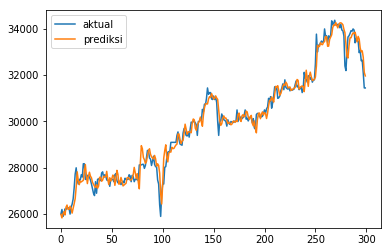

In [0]:
# Plot the prediction result with the real result
df = pd.read_csv('BBCA.JK.csv')
pred = cnn.predict(x_test)
actual = (y_test*(df['Close'].max() - df['Close'].min()) + df['Close'].min())
predicted =  (pred*(df['Close'].max() - df['Close'].min()) + df['Close'].min())
plt.plot(actual, label = 'aktual')
plt.plot(predicted,   label = 'prediksi')
plt.legend()
plt.show()

## Simulasi Transaksi Saham
pada bagian ini, akan dilakukan simulasi transaksi saham dengan menggunakan model yang telah dibuat.

In [0]:
# creating the dataframe that consist of real price and prediction daily
dataframe = pd.DataFrame([actual, predicted.reshape(predicted.shape[0],)]).T
dataframe.columns = ['actual','predicted']

# creating a new column that show the comparison of prediction and reality
predicted_action = [dataframe.loc[i,'predicted']/dataframe.loc[i-1,'actual'] for i in range(1,dataframe.shape[0]) ]
dataframe.loc[1:,'predicted_act'] = predicted_action

In [0]:
# simulation

# initial asset
uang_awal =1000000000
asset_pertama = uang_awal/100

# Confident interval
limit_persen = 3.5
limit = limit_persen/100

# maxixum buy per lot
max_lot = 500

# recapt the asset daily
data_historis_asset = [asset_pertama]
hari = 300

uang_asli = asset_pertama
lembar_saham = 0

for i in range(1,hari):
    # condition : the prediction said it will go up
    if dataframe.loc[i,'predicted_act'] >= 1:
        # Condition : confident interval
        if dataframe.loc[i,'predicted_act']-1 >= limit:
            lot = min(uang_asli//dataframe.loc[i-1,'actual'],max_lot)          
        else:
            lot = min(uang_asli//dataframe.loc[i-1,'actual'],int(max_lot*(dataframe.loc[i,'predicted_act']-1)/limit))
        lembar_saham = lembar_saham + lot
        uang_asli = uang_asli - lot * dataframe.loc[i-1,'actual']
        
    # condition : the prediction said it will go down
    else:
        # Condition : confident interval
        if 1-dataframe.loc[i,'predicted_act'] >= limit:
            lot = lembar_saham
        else :
            lot = int(lembar_saham*(1-dataframe.loc[i,'predicted_act'])/limit)
        lembar_saham = lembar_saham - lot
        uang_asli = uang_asli + lot * dataframe.loc[i-1,'actual']
    # calculating the asset
    data_historis_asset.append([(lembar_saham*dataframe.loc[i-1,'actual'] + uang_asli)*100,lembar_saham,uang_asli*100])

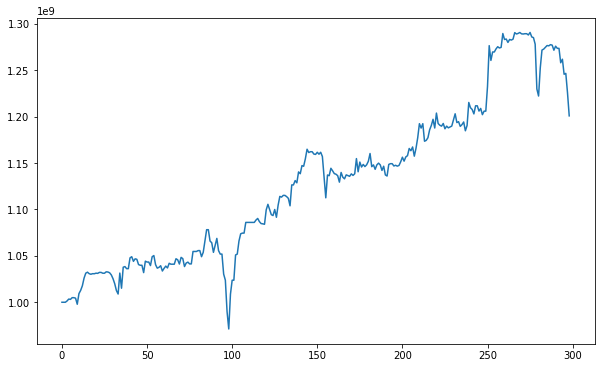

In [0]:
# simulation of stock transaction
plt.figure(figsize=(10,6))
plt.plot(np.array(data_historis_asset[1:])[:,0])

## Terima kasih